In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def excited_state_pop(delta, Omega, t):
    term1 = Omega**2
    term2_1 = np.sqrt(Omega ** 2 + delta ** 2)
    term2 = np.sin(term2_1 * t / 2) ** 2
    numerator = term1 * term2
    denominator = Omega ** 2 + delta ** 2
    return numerator / denominator

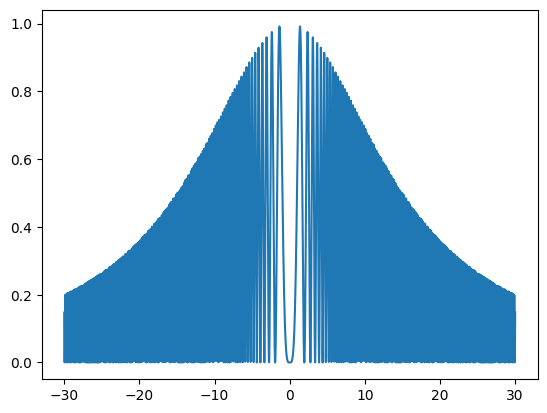

In [23]:
detuning_kHz = np.linspace(-30, 30, 5000)
detunings = detuning_kHz * 1e3 * 2 * np.pi
Omega = 15e3 * 2 * np.pi
t = 8e-3
p_excited = excited_state_pop(detunings, Omega, t)

fig, ax = plt.subplots()
ax.plot(detuning_kHz, p_excited)
plt.show()

In [ ]:
fig, ax = plt.subplots()
